<a href="https://colab.research.google.com/github/lcaspari/42_tensorflow_homework/blob/Melih/homework8/homework08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.keras.layers import Dense, Conv2DTranspose, MaxPool2D, BatchNormalization, Activation, Reshape, LeakyReLU, Dropout, Flatten
from IPython import display

In [ ]:
(train_images, train_labels), (_ , _ ) = tf.keras.datasets.fashion_mnist.load_data()

# preprocessing steps

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5 

BUFFER_SIZE = 60000
BATCH_SIZE = 34

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(train_images.shape, train_labels.shape)


(60000, 28, 28, 1) (60000,)


In [ ]:
# Model --> GAN 

class Generator(tf.keras.Model):
  def __init__(self): 

    super(Generator, self).__init__()
    """ Conv2DTranspose is used to generate a new picture. Upsampling until the goal image size is reached.""" 

    # first layer 
    self.GeneratorLayers = [Dense(7*7*256, use_bias=False, input_shape=(100,)),
                BatchNormalization(),
                LeakyReLU()]


    self.reshape_1 = Reshape(target_shape=(7,7,256))

    # second layer
    self.layer_1 = [Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False),
               BatchNormalization(),
               LeakyReLU()] 
    # third layer
    self.layer_2 = [Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
                    BatchNormalization(),
                    LeakyReLU()]
    self.Conv2DTranspose = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')

    self.GeneratorLayers.append(self.reshape_1)
    self.GeneratorLayers.extend(self.layer_1)
    self.GeneratorLayers.extend(self.layer_2)
    self.GeneratorLayers.append(self.Conv2DTranspose)

  @tf.function    
  def call(self, x, training = True):
    """Activate our model propagating the input through the network layer by layer

    Arguments:
      x (Tensor): Tensor containing the input to our network
      training (Boolean): Indicates whether regularization methods should be used or not when calling the model 

    Returns:
      x (Tensor): Tensor containing the probabilities for the ten classes
    """

    for layer in self.GeneratorLayers:
      x = layer(x, training = training)
    
    return x




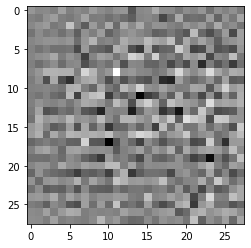

In [ ]:
# generating a picture --> testing Generator
generator = Generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [ ]:
class Discriminator(tf.keras.Model):
  def __init__(self): 
    """ CNN based picture classifier"""
    super(Discriminator, self).__init__()

    self.Discriminator_layers = [Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
                    LeakyReLU(),
                    Dropout(0.3)]

    self.layer_1 = [Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
                    LeakyReLU(),
                    Dropout(0.3)]


    self.layer_2 = [Flatten(), Dense(1)] 

    self.Discriminator_layers.extend(self.layer_1)
    self.Discriminator_layers.extend(self.layer_2)

  @tf.function    
  def call(self, x, training = True):
    """Activate our model propagating the input through the network layer by layer

    Arguments:
      x (Tensor): Tensor containing the input to our network
      training (Boolean): Indicates whether regularization methods should be used or not when calling the model 

    Returns:
      x (Tensor): Tensor containing the probabilities for the ten classes
    """

    for layer in self.Discriminator_layers:
      x = layer(x, training = training)
    return x



In [ ]:
# Using unteached Discriminator to decide wheter generated image is real or not
# pos numbers == real / negative numbers == fake

discriminator = Discriminator()
decision = discriminator(generated_image)
print (decision)


tf.Tensor([[-0.00048007]], shape=(1, 1), dtype=float32)


In [ ]:
# Computing loss 

# This method returns a helper function to compute cross entropy loss
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# determine optimizer
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


def generator_loss(d_pred): 
  """
  d_pred: discriminator's prediction  of the image generated by the generator  
  take cross entropy between predicted label and all labels as 1s
  because we want to minimize the difference between them
  --> the more the discriminator thinks the images are real, the better our generator
  """
  return binary_cross_entropy(tf.ones_like(d_pred), d_pred) # tf.ones_like(d_pred) is same as tf.ones(d_pred.shape)


def discriminator_loss(real_output, fake_output):
  """
  real_output: labels that discriminator predicted when seeing real images (should ideally be all 1s)
  fake_output: labels that discriminator predicted when seeing fake images (should ideally be all 0s)
  """
  real_loss = binary_cross_entropy(tf.ones(real_output.shape), real_output)
  fake_loss = binary_cross_entropy(tf.zeros(fake_output.shape), fake_output)

  return real_loss + fake_loss


In [ ]:
# pseudocode trainingstep GAN

# def training step(generator, discriminator, real_images):

  # create noise
  # feed into generator

  # feed real images into discriminator, get the predictions
  # feed fake images into discriminator, get the predictions
  
  # calculate discr loss 
  # apply the gradients

  # calc gen loss
  # apply gradients 

  # return both losses


# **Training**

In [ ]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
 


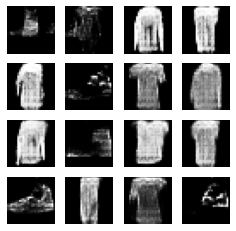

In [ ]:
train(train_dataset, EPOCHS)
